In [1]:
import spectromancer as sp
import corv

from astropy.table import Table, join, vstack
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../')
import WD_models

plt.style.use('stefan.mplstyle')

/home/arsen/miniconda3/envs/core-composition/lib/python3.12/site-packages/corv/models/warwick_da
We could not find the pickled WD models
We could not find the pickled WD models. If you need to use these models, please re-import corv with the proper path.
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [45]:
test1 = Table.read('../data/ADP.2022-02-21T05_02_49.595.fits')
test2 = Table.read('../data/ADP.2022-02-21T05_02_49.605.fits')

In [56]:
test1

WAVE,FLUX_REDUCED,ERR_REDUCED,FLUX,ERR,QUAL,CONTRIB,SNR,QUAL_REDUCED,CONTRIB_REDUCED,SNR_REDUCED
Angstrom,adu,adu,1e-16 erg / (Angstrom s cm2),1e-16 erg / (Angstrom s cm2),,,,,,
float64[67508],float64[67508],float64[67508],float64[67508],float64[67508],int32[67508],int32[67508],float64[67508],int32[67508],int32[67508],float64[67508]
4583.10014054734 .. 6686.39878874714,0.0 .. 0.0,0.7071067811865476 .. 0.7071067811865476,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,2 .. 2,-- .. --,0 .. 0,2 .. 2,0.0 .. 0.0


array([False, False, False, ..., False, False, False])

In [163]:
wave1 = test1['WAVE'].data[0]
flux1 = test1['FLUX'].data[0]
ivar1 = 1 / (test1['ERR'].data[0] + 1e-6)
mask1 = np.all([test1['ERR'].data[0] != 0, flux1 > 0, flux1 < 10], axis=0)

wave2 = test2['WAVE'].data[0]
flux2 = test2['FLUX'].data[0]
ivar2 = 1 / (test2['ERR'].data[0] + 1e-6)
mask2 = np.all([test2['ERR'].data[0] != 0, flux2 > 0, flux2 < 10], axis=0)

wave = np.concatenate([wave1[mask1], wave2[mask2]])
flux = np.concatenate([flux1[mask1], flux2[mask2]])
ivar = np.concatenate([ivar1[mask1], ivar2[mask2]])
uves_spec = sp.Spectrum(wave, flux, ivar)

In [164]:
source_id = 3121385658671190784
obs = sp.Observation('../data/observations/')

In [165]:
target = obs.targets[0]
name, wave, flux, ivar = target.name, target.spectrum.wave, target.spectrum.flux, target.spectrum.ivar
bad = ((wave > 4750) & (wave < 4770)) | ((wave > 4390) & (wave < 4400))

Text(0, 0.5, 'Flux $[erg/s/cm^2/\\AA]$')

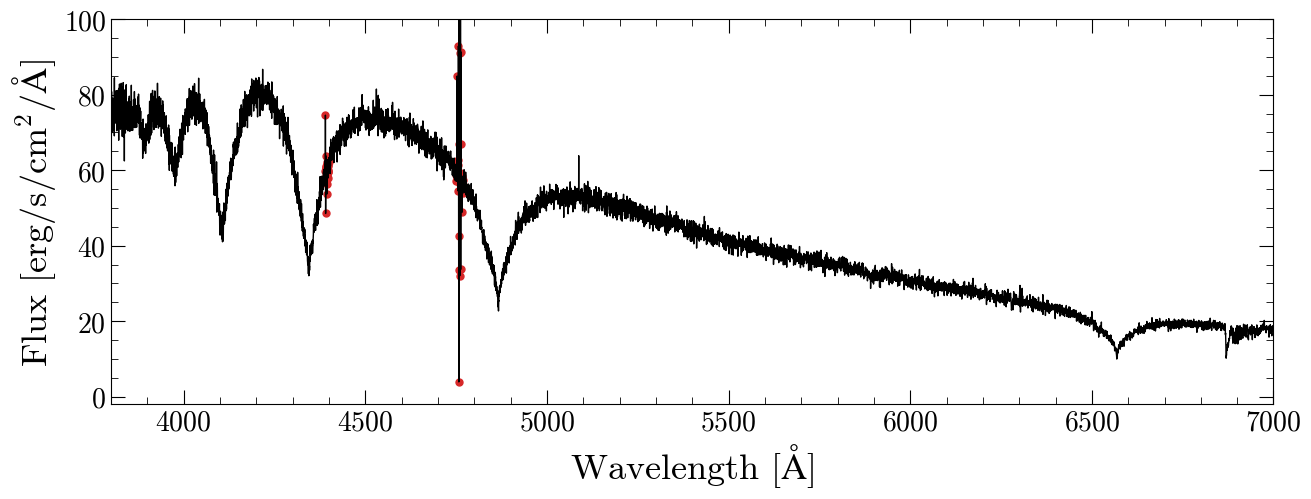

In [166]:
plt.figure(figsize = (15, 5))
plt.plot(wave, flux, lw = 1, color = 'k')
plt.scatter(wave[bad], flux[bad], lw = 1, color = 'C3')
plt.ylim(-2, 100)
plt.xlim(3800, 7000)
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux $[erg/s/cm^2/\AA]$')

In [174]:
clean_sp = sp.Spectrum(wave[~bad], flux[~bad], ivar[~bad])# + uves_spec
corvmodel = corv.models.make_warwick_da_model(names = ['a','b','g','d'])
rv, e_rv, redchi, param_res = clean_sp.fit_rv(corvmodel)
rv, e_rv

(197.2823117074479, 3.248938346250327)

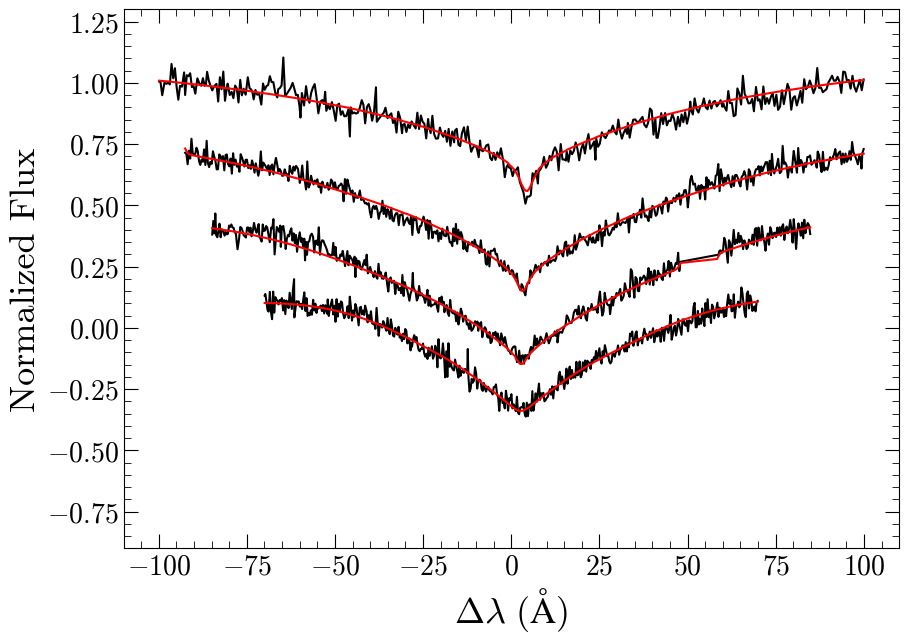

In [175]:
fig = corv.utils.lineplot(wave[~bad], flux[~bad], ivar[~bad], corvmodel, param_res.params, gap = 0.3, printparams = False,
             figsize = (10, 7))
fig.savefig('../figures/example_corvfit.pdf')

In [176]:
clean_sp = sp.Spectrum(wave[~bad], flux[~bad], ivar[~bad]) + uves_spec
corvmodel = corv.models.make_warwick_da_model(names = ['a','b','g','d'])
rv, e_rv, redchi, param_res = clean_sp.fit_rv(corvmodel)
rv, e_rv

(199.4603556638373, 7.288258395369255)

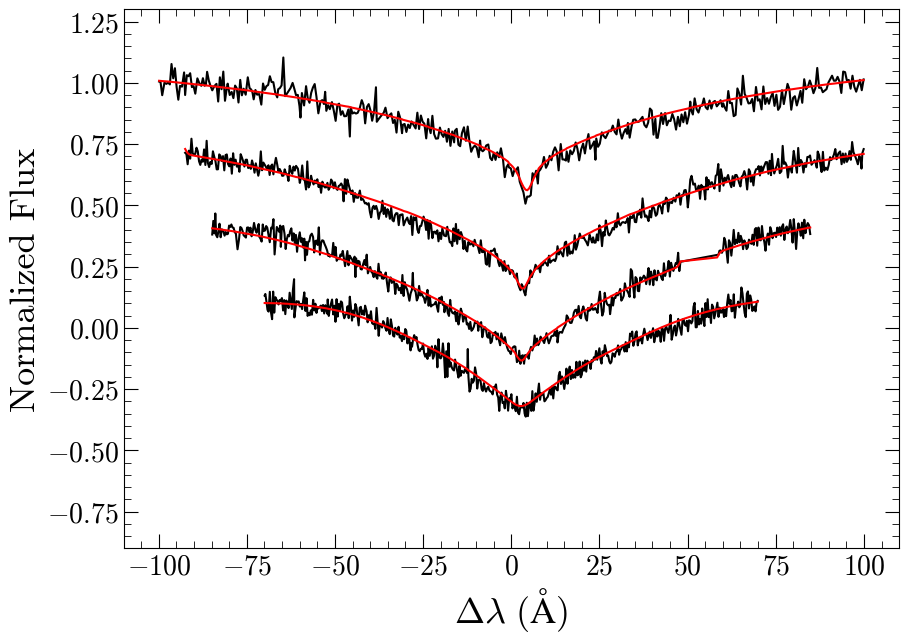

In [177]:
fig = corv.utils.lineplot(wave[~bad], flux[~bad], ivar[~bad], corvmodel, param_res.params, gap = 0.3, printparams = False,
             figsize = (10, 7))

In [7]:
vincent_class = Table.read('https://cdsarc.cds.unistra.fr/viz-bin/nph-Cat/fits?J/A+A/682/A5/catalog.dat.gz')

In [8]:
vincent_class[vincent_class['GaiaDR3'] == source_id]

GaiaDR3,SpType,umag,gmag,rmag,imag,zmag,e_Fluxu,e_Fluxg,e_Fluxr,e_Fluxi,e_Fluxz,PDA,PDB,PDC,PDO,PDQ,PDZ,Teff,logg,M,e_Teff,e_logg,e_M,umagcor,e_umagcor,comp,logCHe,logL,e_logL
,,mag,mag,mag,mag,mag,W / (nm m2),W / (nm m2),W / (nm m2),W / (nm m2),W / (nm m2),,,,,,,K,[cm/s2],Msun,K,[cm/s2],Msun,mag,mag,,,[Lsun],[Lsun]
int64,bytes3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,int32,float64,float64,float64,float64,bytes27,float64,float64,float64
3121385658671190784,DA,17.1668,17.1120,17.3840,17.6658,17.9596,1.33415488569786748e-31,2.76549770986988770e-32,3.04717130823015871e-32,2.98415595084939866e-32,4.57111526958767041e-32,0.95,0.00,0.00,0.00,0.00,0.00,17300,9.220,1.279,432,0.019,0.006,0.0266,0.0488,Pure H,0.000,-2.7687,-0.4242


In [9]:
obj = Table.read('../data/raw/elbadry.csv')
obj = obj[obj['wd_source_id'] == source_id]

In [11]:
from astroquery.gaia import Gaia

def make_physical_photometry(catalog):
    # convert gaia flux into physical units (see documentation)
    catalog['wd_phot_g_mean_flux'] = catalog['wd_phot_g_mean_flux'] * 1.736011e-33 * 2.99792458e+21 / 6217.9**2
    catalog['wd_phot_bp_mean_flux'] = catalog['wd_phot_bp_mean_flux'] * 2.620707e-33 * 2.99792458e+21 / 5109.7**2
    catalog['wd_phot_rp_mean_flux'] = catalog['wd_phot_rp_mean_flux'] * 3.2988153e-33 * 2.99792458e+21 / 7769.1**2

    # then convert the errors
    catalog['wd_phot_g_mean_flux_error'] = catalog['wd_phot_g_mean_flux_error'] * 1.736011e-33 * 2.99792458e+21 / 6217.9**2
    catalog['wd_phot_bp_mean_flux_error'] = catalog['wd_phot_bp_mean_flux_error'] * 2.620707e-33 * 2.99792458e+21 / 5109.7**2
    catalog['wd_phot_rp_mean_flux_error'] = catalog['wd_phot_rp_mean_flux_error'] * 3.2988153e-33 * 2.99792458e+21 / 7769.1**2

    # finally convert the magnitude uncertainties
    catalog['wd_e_gmag'] = catalog['wd_phot_g_mean_flux_error'] / (1.09 * catalog['wd_phot_g_mean_flux'])
    catalog['wd_e_bpmag'] = catalog['wd_phot_bp_mean_flux_error'] / (1.09 * catalog['wd_phot_bp_mean_flux'])
    catalog['wd_e_rpmag'] = catalog['wd_phot_rp_mean_flux_error'] / (1.09 * catalog['wd_phot_rp_mean_flux'])
    return catalog

def get_bailerjones(catalog):
    ADQL_CODE1 = """SELECT dist.source_id, dist.r_med_geo
            FROM gaiadr3.gaia_source as gaia
            JOIN external.gaiaedr3_distance as dist
            ON gaia.source_id = dist.source_id      
            WHERE gaia.source_id = {}""".format(catalog['ms_source_id'][0])
    gaia_d1 = Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results()
    gaia_d1.rename_column('source_id', 'ms_source_id')
    catalog = join(catalog, gaia_d1, keys = 'ms_source_id')
    return catalog

def radius_from_cmd(catalog):
    newton_G = 6.674e-11
    mass_sun = 1.9884e30
    radius_sun = 6.957e8

    model = WD_models.load_model(low_mass_model='Bedard2020',
                                middle_mass_model='Bedard2020',
                                high_mass_model='ONe',
                                atm_type='H',
                                HR_bands=('bp3-rp3', 'G3'))

    bp3_rp3 = catalog['wd_phot_bp_mean_mag'] - catalog['wd_phot_rp_mean_mag']
    G3 = catalog['wd_phot_g_mean_mag'] - 5 * np.log10(catalog['r_med_geo']) + 5
    logg = model['HR_to_logg'](bp3_rp3, G3)
    mass = model['HR_to_mass'](bp3_rp3, G3)

    catalog['cmd_radius'] = np.sqrt((newton_G * mass * mass_sun) / (10**logg/100)) / radius_sun
    return catalog

obj = make_physical_photometry(obj)
obj = get_bailerjones(obj)
obj = radius_from_cmd(obj)

obj = join(obj, vincent_class, keys_left='wd_source_id', keys_right='GaiaDR3')

In [13]:
obj

wd_solution_id,ms_solution_id,wd_source_id,ms_source_id,wd_random_index,ms_random_index,wd_ref_epoch,ms_ref_epoch,wd_ra,ms_ra,wd_ra_error,ms_ra_error,wd_dec,ms_dec,wd_dec_error,ms_dec_error,wd_parallax,ms_parallax,wd_parallax_error,ms_parallax_error,wd_parallax_over_error,ms_parallax_over_error,wd_pm,ms_pm,wd_pmra,ms_pmra,wd_pmra_error,ms_pmra_error,wd_pmdec,ms_pmdec,wd_pmdec_error,ms_pmdec_error,wd_ra_dec_corr,ms_ra_dec_corr,wd_ra_parallax_corr,ms_ra_parallax_corr,wd_ra_pmra_corr,ms_ra_pmra_corr,wd_ra_pmdec_corr,ms_ra_pmdec_corr,wd_dec_parallax_corr,ms_dec_parallax_corr,wd_dec_pmra_corr,ms_dec_pmra_corr,wd_dec_pmdec_corr,ms_dec_pmdec_corr,wd_parallax_pmra_corr,ms_parallax_pmra_corr,wd_parallax_pmdec_corr,ms_parallax_pmdec_corr,wd_pmra_pmdec_corr,ms_pmra_pmdec_corr,wd_astrometric_n_obs_al,ms_astrometric_n_obs_al,wd_astrometric_n_obs_ac,ms_astrometric_n_obs_ac,wd_astrometric_n_good_obs_al,ms_astrometric_n_good_obs_al,wd_astrometric_n_bad_obs_al,ms_astrometric_n_bad_obs_al,wd_astrometric_gof_al,ms_astrometric_gof_al,wd_astrometric_chi2_al,ms_astrometric_chi2_al,wd_astrometric_excess_noise,ms_astrometric_excess_noise,wd_astrometric_excess_noise_sig,ms_astrometric_excess_noise_sig,wd_astrometric_params_solved,ms_astrometric_params_solved,wd_astrometric_primary_flag,ms_astrometric_primary_flag,wd_nu_eff_used_in_astrometry,ms_nu_eff_used_in_astrometry,wd_pseudocolour,ms_pseudocolour,wd_pseudocolour_error,ms_pseudocolour_error,wd_ra_pseudocolour_corr,ms_ra_pseudocolour_corr,wd_dec_pseudocolour_corr,ms_dec_pseudocolour_corr,wd_parallax_pseudocolour_corr,ms_parallax_pseudocolour_corr,wd_pmra_pseudocolour_corr,ms_pmra_pseudocolour_corr,wd_pmdec_pseudocolour_corr,ms_pmdec_pseudocolour_corr,wd_astrometric_matched_transits,ms_astrometric_matched_transits,wd_visibility_periods_used,ms_visibility_periods_used,wd_astrometric_sigma5d_max,ms_astrometric_sigma5d_max,wd_matched_transits,ms_matched_transits,wd_new_matched_transits,ms_new_matched_transits,wd_matched_transits_removed,ms_matched_transits_removed,wd_ipd_gof_harmonic_amplitude,ms_ipd_gof_harmonic_amplitude,wd_ipd_gof_harmonic_phase,ms_ipd_gof_harmonic_phase,wd_ipd_frac_multi_peak,ms_ipd_frac_multi_peak,wd_ipd_frac_odd_win,ms_ipd_frac_odd_win,wd_ruwe,ms_ruwe,wd_scan_direction_strength_k1,ms_scan_direction_strength_k1,wd_scan_direction_strength_k2,ms_scan_direction_strength_k2,wd_scan_direction_strength_k3,ms_scan_direction_strength_k3,wd_scan_direction_strength_k4,ms_scan_direction_strength_k4,wd_scan_direction_mean_k1,ms_scan_direction_mean_k1,wd_scan_direction_mean_k2,ms_scan_direction_mean_k2,wd_scan_direction_mean_k3,ms_scan_direction_mean_k3,wd_scan_direction_mean_k4,ms_scan_direction_mean_k4,wd_duplicated_source,ms_duplicated_source,wd_phot_g_n_obs,ms_phot_g_n_obs,wd_phot_g_mean_flux,ms_phot_g_mean_flux,wd_phot_g_mean_flux_error,ms_phot_g_mean_flux_error,wd_phot_g_mean_flux_over_error,ms_phot_g_mean_flux_over_error,wd_phot_g_mean_mag,ms_phot_g_mean_mag,wd_phot_bp_n_obs,ms_phot_bp_n_obs,wd_phot_bp_mean_flux,ms_phot_bp_mean_flux,wd_phot_bp_mean_flux_error,ms_phot_bp_mean_flux_error,wd_phot_bp_mean_flux_over_error,ms_phot_bp_mean_flux_over_error,wd_phot_bp_mean_mag,ms_phot_bp_mean_mag,wd_phot_rp_n_obs,ms_phot_rp_n_obs,wd_phot_rp_mean_flux,ms_phot_rp_mean_flux,wd_phot_rp_mean_flux_error,ms_phot_rp_mean_flux_error,wd_phot_rp_mean_flux_over_error,ms_phot_rp_mean_flux_over_error,wd_phot_rp_mean_mag,ms_phot_rp_mean_mag,wd_phot_bp_n_contaminated_transits,ms_phot_bp_n_contaminated_transits,wd_phot_bp_n_blended_transits,ms_phot_bp_n_blended_transits,wd_phot_rp_n_contaminated_transits,ms_phot_rp_n_contaminated_transits,wd_phot_rp_n_blended_transits,ms_phot_rp_n_blended_transits,wd_phot_proc_mode,ms_phot_proc_mode,wd_phot_bp_rp_excess_factor,ms_phot_bp_rp_excess_factor,wd_bp_rp,ms_bp_rp,wd_bp_g,ms_bp_g,wd_g_rp,ms_g_rp,wd_dr2_radial_velocity,ms_dr2_radial_velocity,wd_dr2_radial_velocity_error,ms_dr2_radial_velocity_error,wd_dr2_rv_nb_transits,ms_dr2_rv_nb_transits,wd_dr2_rv_template_teff,ms_dr2

In [15]:
import sys
sys.path.append('../')
import corecomposition as cc
from corecomposition import interpolator
import corner
import pickle
from tqdm import tqdm

gaia_chains = {}
base_wavl, model_spec, model_spec_low_logg, table = cc.interpolator.utils.build_warwick_da()
build_spec = lambda best_est, distance : 4*np.pi*model_spec((best_est[0], 9)) * ((best_est[1] * 6.957e8) / (distance * 3.086775e16))**2

distance = obj['r_med_geo'][0]
bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP']
photomet = np.array([obj['wd_phot_g_mean_mag'], obj['wd_phot_bp_mean_mag'], obj['wd_phot_rp_mean_mag']]).T[0]
e_photomet = np.array([obj['wd_e_gmag'], obj['wd_e_bpmag'], obj['wd_e_rpmag']]).T[0]
initial_guess = np.array([obj['Teff'], obj['cmd_radius']]).T[0]

teff_constraint = np.array([obj['Teff'], obj['e_Teff']]).T[0]
if np.all(teff_constraint == np.array([0,0])):
    teff_constraint = np.array([None, None])
    initial_guess = np.array([10000, obj['cmd_radius'][0]])

print(photomet, e_photomet, distance, initial_guess, teff_constraint)

gaia_model = interpolator.WarwickDAInterpolator(bands)
# run the MCMC fit using one of the interpolators
gaia_engine = interpolator.MCMCEngine(gaia_model)
gaia_flat_chain = gaia_engine.run_mcmc(photomet, e_photomet, distance, initial_guess, teff_constraint)
gaia_chains[source_id] = gaia_flat_chain

[17.23731613 17.20028687 17.38391113] [0.00095818 0.00478089 0.00991014] 61.616257 [1.73000000e+04 4.65161707e-03] [17300   432]
17300 432
Auto-Correlation Time = 29.42164850688558, additional steps = -971


In [16]:
def build_radius_table(chain):
    source_ids = list(chain.keys())
    radius_med = []
    radius_low = []
    radius_high = []

    for wdid in source_ids:
        mcmc = np.percentile(chain[wdid][:,1],[16,50,84])
        unc = np.diff(mcmc)
        radius_med.append(mcmc[1])
        radius_low.append(unc[0])
        radius_high.append(unc[1])

    radius_table = Table()
    radius_table['wd_source_id'] = source_ids
    radius_table['radius_med'] = radius_med
    radius_table['radius_unc_low'] = radius_low
    radius_table['radius_unc_high'] = radius_high
    radius_table['e_radius'] = 0.5 * np.abs(radius_table['radius_unc_high'] + radius_table['radius_unc_low'])
    radius_table['pct_error'] = radius_table['e_radius'] / radius_table['radius_med'] * 100
    return radius_table

radius_table = build_radius_table(gaia_chains)

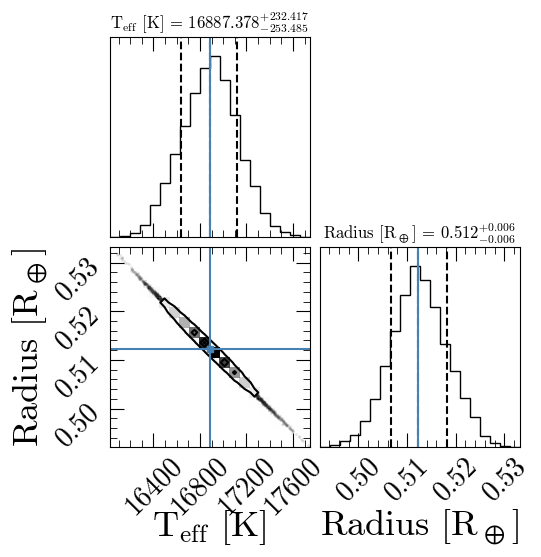

In [17]:
labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\oplus]$']
best_est = np.zeros((len(labels)))
unc = []

temp_chain = gaia_chains[source_id]
temp_chain[:, 1] *= 109.075

for i in range(len(labels)):
    mcmc = np.percentile(temp_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(temp_chain, labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

plt.show()

In [18]:
radius_table

wd_source_id,radius_med,radius_unc_low,radius_unc_high,e_radius,pct_error
int64,float64,float64,float64,float64,float64
3121385658671190784,0.0046968087421365295,5.110394679621894e-05,5.503858613617116e-05,5.307126646619505e-05,1.129943103496556


In [21]:
obj[['wd_source_id', 'wd_phot_bp_rp_excess_factor', 'wd_ruwe', 'wd_ra', 'wd_dec']]

wd_source_id,wd_phot_bp_rp_excess_factor,wd_ruwe,wd_ra,wd_dec
int64,float64,float64,float64,float64
3121385658671190784,1.1181485652923584,0.9942895174026489,92.21438403314589,-0.9974533046455966


In [180]:
from astropy.io import fits

aaa = fits.open('../data/observations/j0608m0059/j0608m0059_coadd.fits')

In [182]:
aaa

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f0357d768a0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f0357cdb950>]

In [181]:
aaa[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
VERSPYT = '3.11.8  '           / Python version                                 
VERSNPY = '1.26.4  '           / Numpy version                                  
VERSSCI = '1.12.0  '           / Scipy version                                  
VERSAST = '6.0.0   '           / Astropy version                                
VERSSKL = '1.4.1.post1'        / Scikit-learn version                           
VERSPYP = '1.15.0  '           / PypeIt version                                 
DATE    = '2024-04-01'         / UTC date created                               
RA      =    92.21208333333333 / (J2000) RA in decimal degrees                  
DEC     =  -0.99711111111111